In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
import scipy.stats as stats

In [5]:
import scikit_posthocs as sp

In [6]:
def donor(df, int):
    mask = df['DONOR_ID'] == int
    return df[mask]

In [7]:
def get_dupes(list):
    my_list = list
    count_dict = {}
    for item in my_list:
        if item in count_dict:
            count_dict[item] += 1
        else:
            count_dict[item] = 1
    
    duplicates = [item for item, count in count_dict.items() if count > 1]
    return duplicates

In [8]:
def pt(df, int):
    mask = df['WL_ID_CODE'] == int
    return df[mask]

In [25]:
def get_era(date_time):
    ts1 = pd.Timestamp(2015, 10, 8)
    ts2 = pd.Timestamp(2019, 5, 13, 23, 59, 59)
    ts3 = pd.Timestamp(2020, 2, 3, 23, 59, 59)
    ts4 = pd.Timestamp(2022, 6, 27, 23, 59, 59)
    if (date_time >= ts1) & (date_time < ts2):
        return 1
    elif (date_time >= ts2) & (date_time < ts3):
        return 2
    elif (date_time >= ts3) & (date_time < ts4):
        return 3
    else:
        return None


In [38]:
def off_eras_var(var, df):
    era1 = df[df['OFFER_ERA'] == 1]
    era2 = df[df['OFFER_ERA'] == 2]
    era3 = df[df['OFFER_ERA'] == 3]
    df_list = [era1, era2, era3]
    ser_list = []
    for i, era in enumerate(df_list):
        ser = era[var].dropna().rename('era'+str((i+1))+' - '+var).reset_index(drop=True)
        ser_list.append(ser)
    return pd.concat(ser_list, axis=1)

In [39]:
def list_eras_var(var, df):
    era1 = df[df['LIST_ERA'] == 1]
    era2 = df[df['LIST_ERA'] == 2]
    era3 = df[df['LIST_ERA'] == 3]
    df_list = [era1, era2, era3]
    ser_list = []
    for i, era in enumerate(df_list):
        ser = era[var].dropna().rename('era'+str((i+1))+' - '+var).reset_index(drop=True)
        ser_list.append(ser)
    return pd.concat(ser_list, axis=1)

In [40]:
def tot_secs(x):
   return x.total_seconds()

In [110]:
def kw_group(df):
    l = []
    for i in range(df.columns.size):
        l.append(df.iloc[:, i].dropna().tolist())
    return l

In [9]:
ptr = pd.read_stata('PTR_CLEAN.DTA')

In [10]:
vars = pd.read_excel('Vars.xlsx', sheet_name='Sheet1')

In [11]:
ld = pd.read_stata('LIVER_DATA.DTA', columns = vars['ld_cols'].dropna())

In [12]:
dd = pd.read_stata('DECEASED_DONOR_DATA.DTA', columns = vars['dd_cols'].dropna())

In [13]:
ld.rename(columns = {'DONOR_ID':'LD_DONOR_ID', 'LISTING_CTR_CODE' : 'LD_LISTING_CTR_CODE'}, inplace=True)

In [14]:
dd.rename(columns =  {'OPO_CTR_CODE' : 'DD_OPO_CTR_CODE'}, inplace=True)

In [15]:
for col in ld.columns:
    if col in dd.columns.tolist():
        dd.rename(columns={col: 'DD_'+col}, inplace=True)
    else:
        pass

In [16]:
dict = {}
for i in range(ld.shape[0]):
    if ld.iloc[i]['HCC_DIAG'] == 'Y':
        dict[i] = 1
    elif ld.iloc[i]['HCC_DIAGNOSIS_TCR'] == 'Y':
        dict[i] = 1
    else:
        dict[i] = 0
ser = pd.Series(dict, name='HCC')

In [17]:
ld = pd.concat([ld, ser], axis=1)

In [18]:
dict = {}

In [19]:
for i in range(ld.shape[0]):
    if ld.iloc[i]['DIAG'] == 4403 :
        dict[i] = 1
    elif ld.iloc[i]['DIAG'] == 4420:
        dict[i] = 1
    else:
        dict[i] = 0

In [20]:
ser1 = pd.Series(dict, name='CHOL')

In [21]:
ld = pd.concat([ld, ser1], axis=1)

In [22]:
ptr.rename(columns={'wl_id_code':'WL_ID_CODE'}, inplace=True)

In [23]:
df = ptr.merge(ld, how='left', on='WL_ID_CODE')

In [24]:
df = df.merge(dd, how='left', on='DONOR_ID')

In [26]:
#build offer + listing era

In [27]:
list_era_dict = {}
offer_era_dict = {}
for i in range(df.shape[0]):
    offer = df.iloc[i]
    lt = offer['INIT_DATE']
    ot = offer['MATCH_DATE_TIME']
    list_era_dict[i] = get_era(lt)
    offer_era_dict[i] = get_era(ot)
    

In [28]:
ser1 = pd.Series(list_era_dict, name='LIST_ERA')
ser2 = pd.Series(offer_era_dict, name='OFFER_ERA')
mdf = pd.concat([ser1, ser2, df], axis=1)

In [31]:
mdf = mdf[mdf['INIT_DATE'] >= ts1]

In [32]:
mdf.to_stata('mdf.DTA')

In [33]:
hcc = mdf[mdf['HCC'] == 1]

In [34]:
chol = mdf[mdf['CHOL'] == 1]

In [63]:
ts1 = pd.Timestamp(2015, 10, 8)
ts2 = pd.Timestamp(2019, 5, 13, 23, 59, 59)
ts3 = pd.Timestamp(2020, 2, 3, 23, 59, 59)
ts4 = pd.Timestamp(2022, 6, 27, 23, 59, 59)

***

# **START HERE**

***

In [35]:
#Calculate times to accepted offer + time to first offer for HCC
dict = {'TIME_TO_ACCEPT' : [],
         'TIME_TO_FIRST' : [],
         'WL_ID_CODE' : []}
for id in hcc['WL_ID_CODE'].unique().tolist():
    pat = pt(hcc, id)
    fot = pat['MATCH_DATE_TIME'].min()
    ttfo = fot - pat['INIT_DATE'].iloc[0]
    dict['WL_ID_CODE'].append(id)
    dict['TIME_TO_FIRST'].append(ttfo)
    try:
        oat = pat[pat['OFFER_ACCEPT'] == 'Y']['FINAL_RESPONSE_DATE_TIME'].iloc[0]
        ttoa = oat - pat['INIT_DATE'].iloc[0]
        dict['TIME_TO_ACCEPT'].append(ttoa)
    except IndexError:
        dict['TIME_TO_ACCEPT'].append(None) 
        pass
times = pd.DataFrame(dict)    
hcc = hcc.merge(times, how='left', on='WL_ID_CODE')

In [36]:
#Calculate times to accepted offer + time to first offer for cholangio
dict = {'TIME_TO_ACCEPT' : [],
         'TIME_TO_FIRST' : [],
         'WL_ID_CODE' : []}
for id in chol['WL_ID_CODE'].unique().tolist():
    pat = pt(chol, id)
    fot = pat['MATCH_DATE_TIME'].min()
    ttfo = fot - pat['INIT_DATE'].iloc[0]
    dict['WL_ID_CODE'].append(id)
    dict['TIME_TO_FIRST'].append(ttfo)
    try:
        oat = pat[pat['OFFER_ACCEPT'] == 'Y']['FINAL_RESPONSE_DATE_TIME'].iloc[0]
        ttoa = oat - pat['INIT_DATE'].iloc[0]
        dict['TIME_TO_ACCEPT'].append(ttoa)
    except IndexError:
        dict['TIME_TO_ACCEPT'].append(None) 
        pass
times = pd.DataFrame(dict)
chol = chol.merge(times, how='left', on='WL_ID_CODE')

In [37]:
ao_hcc = hcc[hcc['OFFER_ACCEPT'] == 'Y']

In [99]:
ao_chol = chol[chol['OFFER_ACCEPT'] == 'Y']

In [88]:
hcc_seconds = hcc

In [93]:
hcc_seconds['TIME_TO_ACCEPT'] = hcc_seconds['TIME_TO_ACCEPT'].map(tot_secs)

In [94]:
hcc_seconds['TIME_TO_FIRST'] = hcc_seconds['TIME_TO_FIRST'].map(tot_secs)

In [41]:
TTA = off_eras_var('TIME_TO_ACCEPT', ao_hcc)

In [42]:
TTF = off_eras_var('TIME_TO_FIRST', ao_hcc)

In [100]:
SEQ = off_eras_var('PTR_SEQUENCE_NUM', hcc)

In [46]:
TTA_secs = TTA.map(tot_secs)

In [47]:
TTF_secs = TTF.map(tot_secs)

## **Statistical tests**
-Kruskal-Wallis (3 IV ANOVA)<br>
-Post-hoc Dunn, , 'bonferroni' adjustment


In [57]:
group1 = TTF_secs.iloc[:, 0].dropna().tolist()
group2 = TTF_secs.iloc[:, 1].dropna().tolist()
group3 = TTF_secs.iloc[:, 2].dropna().tolist()

In [123]:
kr1 = stats.kruskal(kw_group(TTA_secs)[0], kw_group(TTA_secs)[1], kw_group(TTA_secs)[2])

In [ ]:
#Time to accept

In [124]:
kr1

KruskalResult(statistic=50.98670336386359, pvalue=8.47965219308899e-12)

In [121]:
kr2 = stats.kruskal(kw_group(TTF_secs)[0], kw_group(TTF_secs)[1], kw_group(TTF_secs)[2])

In [ ]:
#Time to first

In [122]:
kr2

KruskalResult(statistic=329.40965438032055, pvalue=2.948508665514453e-72)

In [115]:
kr3 = stats.kruskal(kw_group(SEQ)[0], kw_group(SEQ)[1], kw_group(SEQ)[2])

In [ ]:
#PTR Sequence Num

In [120]:
kr3

KruskalResult(statistic=8459.542894272836, pvalue=0.0)

In [126]:
ao_hcc.reset_index(drop=True, inplace=True)

In [127]:
ao_hcc = ao_hcc[ao_hcc['OFFER_ERA'].notna()]

In [163]:
post_hoc_TTA = sp.posthoc_dunn(ao_hcc, val_col='TIME_TO_ACCEPT', group_col='OFFER_ERA', p_adjust = 'bonferroni')

In [161]:
post_hoc_TTF = sp.posthoc_dunn(ao_hcc, val_col='TIME_TO_FIRST', group_col='OFFER_ERA', p_adjust = 'bonferroni')

In [162]:
post_hoc_SEQ = sp.posthoc_dunn(hcc[hcc['OFFER_ERA'].notna()], val_col='PTR_SEQUENCE_NUM', group_col='OFFER_ERA', p_adjust = 'bonferroni')

***

#  Tables

In [ ]:
#Time to Accept - Post Hoc dunn test

In [164]:
post_hoc_TTA

,1.0,2.0,3.0
1.0,1.000000e+00,2.604712e-08,5.553105e-08
2.0,2.604712e-08,1.000000e+00,1.806774e-01
3.0,5.553105e-08,1.806774e-01,1.000000e+00


In [165]:
#Time to First - Post Hoc dunn test

In [166]:
post_hoc_TTF

,1.0,2.0,3.0
1.0,1.000000e+00,1.000000e+00,3.984522e-68
2.0,1.000000e+00,1.000000e+00,1.290536e-28
3.0,3.984522e-68,1.290536e-28,1.000000e+00


In [167]:
#PTR_SEQUENCE_NUM - Post Hoc dunn test

In [168]:
post_hoc_SEQ

,1.0,2.0,3.0
1.0,1.000000e+00,3.147908e-85,0.0
2.0,3.147908e-85,1.000000e+00,0.0
3.0,0.000000e+00,0.000000e+00,1.0


In [151]:
SEQ.describe()

,era1 - PTR_SEQUENCE_NUM,era2 - PTR_SEQUENCE_NUM,era3 - PTR_SEQUENCE_NUM
count,153482.000000,39026.000000,244637.000000
mean,605.286209,353.135858,630.812972
std,1307.704351,850.095030,1108.768717
min,1.000000,1.000000,1.000000
25%,17.000000,18.000000,35.000000
50%,71.000000,60.000000,124.000000
75%,364.750000,227.000000,562.000000
max,9928.000000,9353.000000,7987.000000


In [152]:
TTF.describe()

,era1 - TIME_TO_FIRST,era2 - TIME_TO_FIRST,era3 - TIME_TO_FIRST
count,6301,1404,4216
mean,63 days 15:26:11.735756229,64 days 15:24:16.465811966,46 days 17:24:24.718453510
std,77 days 22:02:52.453680940,88 days 19:39:29.481551957,86 days 22:47:30.603115715
min,0 days 06:14:20,0 days 12:30:06,0 days 09:38:05
25%,7 days 18:33:43,7 days 22:37:29.750000,3 days 19:56:38.500000
50%,29 days 09:17:14,28 days 21:41:53,14 days 11:17:20
75%,92 days 02:37:52,88 days 05:03:02.500000,48 days 16:50:04.250000
max,682 days 19:46:40,1027 days 08:22:00,1438 days 05:14:42


In [153]:
TTA.describe()

,era1 - TIME_TO_ACCEPT,era2 - TIME_TO_ACCEPT,era3 - TIME_TO_ACCEPT
count,6301,1404,4216
mean,230 days 02:27:12.855102364,275 days 00:20:35.726495728,283 days 23:44:45.526565464
std,178 days 11:04:56.960755288,235 days 19:53:21.131715924,279 days 09:43:14.189177336
min,0 days 13:39:00,0 days 13:55:00,0 days 13:28:00
25%,77 days 11:40:00,108 days 06:17:45,84 days 13:08:30
50%,217 days 03:09:00,239 days 21:59:00,229 days 08:13:00
75%,314 days 19:53:00,356 days 15:03:00,358 days 02:06:45
max,1270 days 20:27:00,1496 days 23:18:00,2305 days 04:38:00


array([<Axes: xlabel='PTR_SEQ_NUM', ylabel='Frequency'>,
       <Axes: xlabel='PTR_SEQ_NUM', ylabel='Frequency'>,
       <Axes: xlabel='PTR_SEQ_NUM', ylabel='Frequency'>], dtype=object)

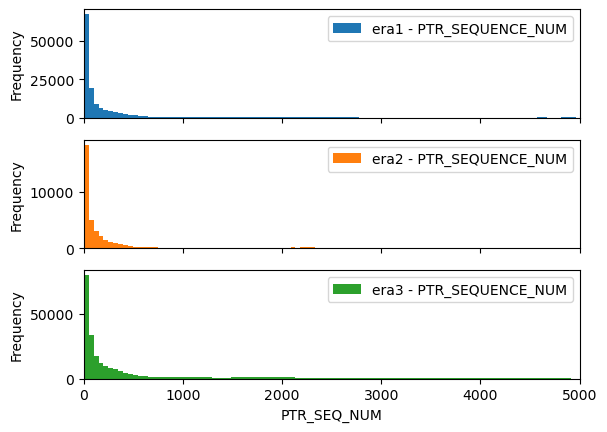

In [160]:
SEQ.plot(kind = 'hist', bins=200, xlabel='PTR_SEQ_NUM', xlim=(0, 5000) ,  subplots=True)

***

In [147]:
chol['TIME_TO_FIRST'] = chol['TIME_TO_FIRST'].map(tot_secs)

In [148]:
chol['TIME_TO_ACCEPT'] = chol['TIME_TO_ACCEPT'].map(tot_secs)

In [149]:
hcc.to_stata('HCC_COHORT.DTA', write_index=False)

In [150]:
chol.to_stata('CHOL_COHORT.DTA', write_index=False)

In [76]:
#If were only looking at offers 2015+, issues w/ # of offers time to first offer  because many pts listed before 2015
#were recieving offers before the period. Could always go back and pull their prev. ones too

In [ ]:
#Same deal with graft offers before acceptance. 

In [ ]:
#Time to offer acceptance = (Listing date - final response time) for accepted offers? Or should it be 
#time of policy change - final response
#What about people with no accepted offers?

In [ ]:
#For each pt - Median sequence number of all their offers during each period?

In [ ]:
#I want to return a table of just patients with relevant PTR data extracted from it. 

In [ ]:
#For each era calculate: offers recieved, time to first offer, time to final offer